# Multi Controlled U Gate

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Operator, Statevector
from qiskit.circuit.library import UnitaryGate
from scipy.linalg import sqrtm

## Functions

In [2]:
def multi_controlled_u_circuit(n: int, U: np.ndarray) -> QuantumCircuit:
    """
    Creates a multi-controlled U gate (C^n U) using a recursive decomposition.

    This implementation is based on the decomposition described in Barenco et al., 1995,
    which constructs a C^n U gate from C^{n-1} V gates (where V^2 = U) and
    a multi-controlled Toffoli (MCX) gate.

    Args:
        n (int): The number of control qubits. Must be a positive integer.
        U (np.ndarray): The 2x2 unitary matrix for the target gate.

    Returns:
        QuantumCircuit: A quantum circuit implementing the C^n U gate.
    """
    if not isinstance(n, int) or n < 1:
        raise ValueError("Number of control qubits 'n' must be a positive integer.")
    if not isinstance(U, np.ndarray) or U.shape != (2, 2) or not np.allclose(U.conj().T @ U, np.identity(2)):
        raise ValueError("U must be a 2x2 numpy array representing a unitary matrix.")

    # --- Define Quantum Registers ---
    # n control qubits, 1 target qubit
    controls = QuantumRegister(n, name='control')
    target = QuantumRegister(1, name='target')
    
    # Ancilla qubits may be needed for the multi-controlled Toffoli gates
    # The number of ancillas for the default 'noancilla' mode of mcx is n-2.
    num_ancillas = max(0, n - 2)
    ancillas = AncillaRegister(num_ancillas, name='ancilla')
    
    # Qiskit orders qubits by concatenating registers: [controls, target, ancillas]
    # The state vector is thus |ancillas, target, controls>
    qc = QuantumCircuit(controls, target, ancillas, name=f'C^{n}U')

    # --- Base Cases for the Recursion ---
    if n == 1:
        # For a single control qubit, Qiskit's .control() is straightforward.
        qc.append(UnitaryGate(U).control(1), [controls[0], target[0]])
        return qc
    
    if n == 2:
        # For two control qubits (Toffoli-controlled U), we use a specific decomposition
        # using controlled square-root gates.
        
        # Calculate V such that V @ V = U.
        # We also need a global phase correction.
        det_U = np.linalg.det(U)
        alpha = np.angle(det_U) / 2.0 
        
        # V = sqrt(U) * e^(-i*alpha/2) to make V special unitary
        V = sqrtm(U * np.exp(-1j * alpha))
        V_gate = UnitaryGate(V, label=r'V')
        Vdg_gate = UnitaryGate(V.conj().T, label=r'$V^\dagger$')

        # Apply the decomposition C(C(U))
        qc.append(V_gate.control(1), [controls[1], target[0]])
        qc.cx(controls[0], controls[1])
        qc.append(Vdg_gate.control(1), [controls[1], target[0]])
        qc.cx(controls[0], controls[1])
        qc.append(V_gate.control(1), [controls[0], target[0]])
        
        # Apply global phase correction to the first control qubit
        qc.p(alpha, controls[0])
        return qc


    # --- Recursive Step for n > 2 ---
    # Decompose C^n U using C^{n-1} gates.
    
    # Calculate V such that V @ V = U
    V = sqrtm(U)
    V_gate = UnitaryGate(V, label=r'V')
    Vdg_gate = UnitaryGate(V.conj().T, label=r'$V^\dagger$')
    
    control_qubits = list(controls)
    
    # Build the C^{n-1}V gate recursively
    cn_minus_1_v_circuit = multi_controlled_u_circuit(n - 1, V)
    cn_minus_1_v_gate = cn_minus_1_v_circuit.to_gate(label=fr'$C^{{{n-1}}}V$')
    
    # The decomposition for C^n U involves:
    # C(V) controlled by the last control qubit on the target
    qc.append(V_gate.control(1), [controls[n-1], target[0]])

    # C^{n-1}X (mcx) from the first n-1 controls to the last control
    qc.mcx(control_qubits[:n-1], controls[n-1], ancilla_qubits=list(ancillas))

    # C(Vdg) controlled by the last control qubit on the target
    qc.append(Vdg_gate.control(1), [controls[n-1], target[0]])

    # C^{n-1}X (mcx) again to uncompute the change on the last control
    qc.mcx(control_qubits[:n-1], controls[n-1], ancilla_qubits=list(ancillas))

    # C^{n-1}V gate on the first n-1 controls and the target
    # The sub-circuit built on n-1 controls may require its own ancillas.
    # We provide them from the pool of ancillas in the main circuit.
    num_ancillas_sub = max(0, (n - 1) - 2)
    sub_qubits = list(controls[:n-1]) + [target[0]] + list(ancillas[:num_ancillas_sub])
    qc.append(cn_minus_1_v_gate, sub_qubits)

    return qc

In [3]:
def run(n_controls, U_matrix, verify=False, save_fig=False):

    print(f"--- Building a C^{n_controls}U Gate ---")
    print(f"Number of controls (n): {n_controls}")
    print("Unitary matrix U:\n", np.round(U_matrix, 3))

    # Get the circuit
    circuit = multi_controlled_u_circuit(n_controls, U_matrix)

    print("\nCircuit generated successfully.")

    # --- Verification Step ---
    print("\n--- Verifying the circuit's unitary matrix ---")

    # This new verification method directly checks the action of the circuit on the
    # key basis state, avoiding the complex and error-prone construction of the
    # full unitary matrix.

    num_ancillas = max(0, n_controls - 2)
    total_qubits = n_controls + 1 + num_ancillas
    dim = 2**total_qubits

    # Create the specific input state we care about: |a=0...0, t=0, c=1...1>
    # Qiskit's state vector is |ancillas, target, controls>, so controls are the LSBs.
    initial_state_int = 2**n_controls - 1
    initial_state = Statevector.from_int(initial_state_int, dims=dim)

    # Evolve this state through the circuit
    final_state = initial_state.evolve(circuit)

    # Construct the state we expect to get
    # It should be a superposition of |a=0,t=0,c=1..1> and |a=0,t=1,c=1..1>
    expected_state_vec = np.zeros(dim, dtype=complex)

    # Index for |...00...11> (target is 0)
    idx0 = initial_state_int
    # Index for |...01...11> (target is 1)
    idx1 = initial_state_int + 2**n_controls

    # The U gate acts on the target qubit, which is initially |0>
    expected_state_vec[idx0] = U_matrix[0, 0] 
    expected_state_vec[idx1] = U_matrix[1, 0] 
    expected_state = Statevector(expected_state_vec)

    # The .equiv() method checks for equality up to a global phase
    is_correct = final_state.equiv(expected_state)

    if is_correct:
        print("\nVerification successful! The circuit correctly transforms the state |11...1>|0>.")
    else:
        print("\nVerification failed. The circuit's output state does not match the expected state.")
        print("Final state vector:\n", np.round(final_state.data, 2))
        print("Expected state vector:\n", np.round(expected_state.data, 2))
        
    if save_fig == True:
        drawing = circuit.draw(output='mpl',style='iqp-dark')
        drawing.savefig('multi_controlled_u_circuit_'+str(n_controls)+'_controls.png')
        print("\nCircuit diagram saved to 'multi_controlled_u_circuit.png'")

    return circuit
        

## Examples

Let $U = \begin{pmatrix}
\cos \theta/2  & -i \sin\theta/2 \\
-i \sin\theta/2 & \cos \theta/2
\end{pmatrix}$ and let $\theta = \pi/4$. Then, we may cosntruct for different $n$ as follows:

#### $n=3$

--- Building a C^3U Gate ---
Number of controls (n): 3
Unitary matrix U:
 [[0.924+0.j    0.   -0.383j]
 [0.   -0.383j 0.924+0.j   ]]

Circuit generated successfully.

--- Verifying the circuit's unitary matrix ---

Verification successful! The circuit correctly transforms the state |11...1>|0>.


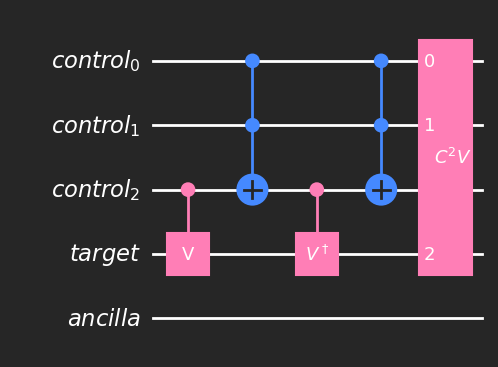

In [4]:
# Number of control qubits
n_controls = 3

# Define a unitary matrix U (e.g., RX gate)
theta = np.pi / 4
U_matrix = np.array([
    [np.cos(theta / 2), -1j * np.sin(theta / 2)],
    [-1j * np.sin(theta / 2), np.cos(theta / 2)]
])
circuit =  run(n_controls, U_matrix, verify=True, save_fig=False)
circuit.draw(output='mpl',style='iqp-dark')

#### $n=5$

--- Building a C^5U Gate ---
Number of controls (n): 5
Unitary matrix U:
 [[0.924+0.j    0.   -0.383j]
 [0.   -0.383j 0.924+0.j   ]]

Circuit generated successfully.

--- Verifying the circuit's unitary matrix ---

Verification successful! The circuit correctly transforms the state |11...1>|0>.


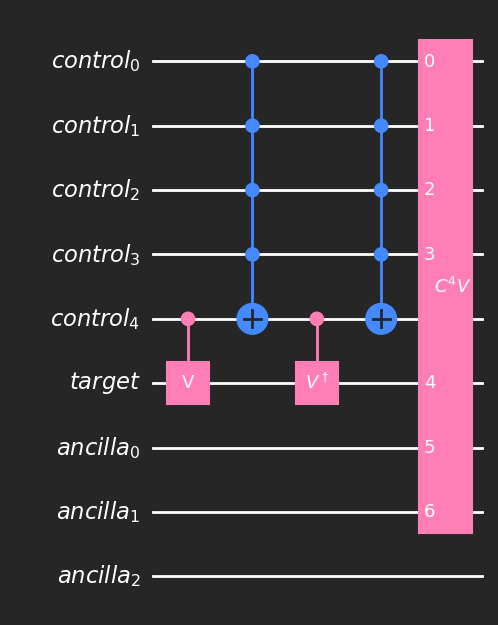

In [7]:
# Number of control qubits
n_controls = 5

circuit =  run(n_controls, U_matrix, verify=True, save_fig=False)
circuit.draw(output='mpl',style='iqp-dark')


#### $n=10$

--- Building a C^10U Gate ---
Number of controls (n): 10
Unitary matrix U:
 [[0.924+0.j    0.   -0.383j]
 [0.   -0.383j 0.924+0.j   ]]

Circuit generated successfully.

--- Verifying the circuit's unitary matrix ---

Verification successful! The circuit correctly transforms the state |11...1>|0>.


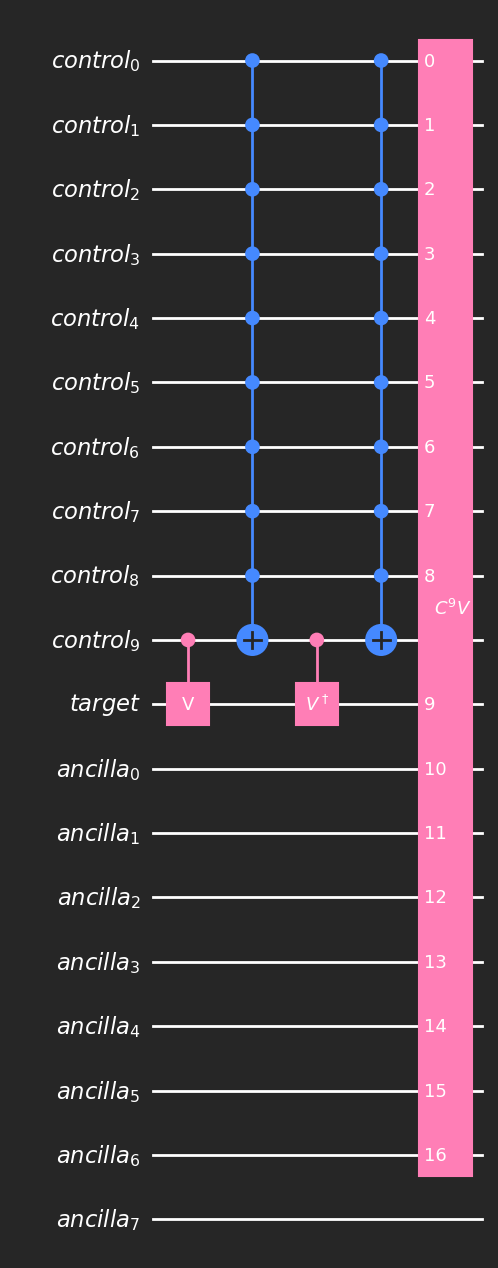

In [8]:
# Number of control qubits
n_controls = 10

circuit =  run(n_controls, U_matrix, verify=True, save_fig=False)
circuit.draw(output='mpl',style='iqp-dark')
